In [1]:
# PROJ518 - Cotton Disease Identification
# Goel Biju (10576090)

# Baseline Models

# TensorFlow version 2
# %tensorflow_version 2.x

import tensorflow as tf
print("TensorFlow version: " + tf.__version__)

# Find GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras import optimizers

import numpy as np

import cv2
from matplotlib import pyplot as plt

import os
import shutil

# Fix random seed for reproducibility?
np.random.seed(42)

TensorFlow version: 2.9.1
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [ ]:
from google.colab import drive

# Importing the dataset (stored in Google Drive)
drive.mount("/content/drive", force_remount=True)

# !ls "/content/drive/MyDrive/Cotton Dataset/data"

In [ ]:
!rm -rf Cotton-Disease-Identification

!git clone https://github.com/GoelBiju/Cotton-Disease-Identification

In [3]:
# data_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data"
data_dir = "/notebooks/Cotton-Disease-Identification/data"

# Model parameters
epochs = 50 # 10, 25, 50, 100
batch_size = 32 # 32, 64, 128
data_augmentation = False

In [4]:
# See the number of classes available
for image_class in os.listdir(data_dir + '/train'):
    print(image_class)

# img = cv2.imread(os.path.join(data_dir, 'healthy', 'IMG_20210927_132155_103.jpg'))
# img.shape

# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

healthy
leaf_curl
.DS_Store


In [5]:
# Load in data
# data = tf.keras.utils.image_dataset_from_directory(data_dir)

# default batch size of 32, image size 256x256

train_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'), 
    image_size=(256, 256),
    batch_size=batch_size, 
    label_mode="binary",
    seed=42)

val_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(256, 256), 
    batch_size=batch_size,
    label_mode="binary",
    seed=42)

print(train_data.class_names)


Found 1318 files belonging to 2 classes.
Found 376 files belonging to 2 classes.
['healthy', 'leaf_curl']


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(32, 256, 256, 3)
(32, 1)


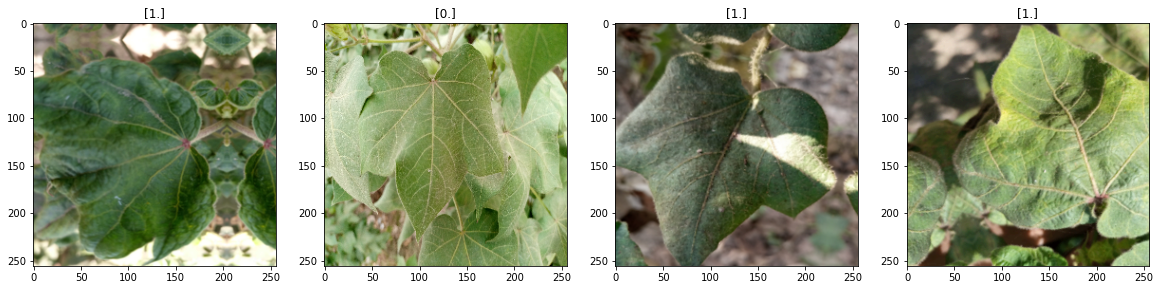

In [6]:
# Show some samples of training data
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    

# print(train_data.cardinality().numpy())

# for i, (x, y) in enumerate(train_data):
#     print(i, x.numpy().shape, y.numpy().shape)

In [7]:
# Performance on the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Scale the data
# data = data.map(lambda x, y: (x / 255, y))

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_train_data))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0, 1]`.
# print(np.min(first_image), np.max(first_image))


# train_data.as_numpy_iterator().next()

In [ ]:
# # Split Data - 70%, 20%, 10% splits for the train, validation and testing datasets
# train_size = int(len(data) * .7)
# val_size = int(len(data) * .2)
# test_size = int(len(data) * .1)

# train_size

# train = data.take(train_size)
# val = data.skip(train_size).take(val_size)
# test = data.skip(train_size + val_size).take(test_size)

# train

In [9]:
# Create the architecture for the deep learning model

# Clear any previous models created to prevent
# adding unnecessary layers when testing again
tf.keras.backend.clear_session()

# Initial model
model = Sequential()

In [ ]:
# # Model (Baseline 1) architecture
# baseline_num = 1

# model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3), 1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(16, (3, 3), 1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
          
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
          
# model.add(Dense(1, activation='sigmoid'))

In [10]:
# Model (Baseline 2) architecture
baseline_num = 2

# "Conv1" - filter size = 5x5, # of filter = 192, pad = 2, stride = 1, Act. = ReLU
model.add(Conv2D(192, kernel_size=(5, 5), activation='relu', strides=1, input_shape=(256, 256, 3)))
# Zero padding is applied to following layers
model.add(ZeroPadding2D(padding=2))
# "mlp 1" - filter size = 1x1, # of filter = 160, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(160, activation='relu'))
# "mlp 2" - filter size = 1x1, # of filter = 96, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(96, activation='relu'))
# "Pool 1" - 3x3 max pooling, stride = 2
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# Dropout 0.5
model.add(Dropout(0.5))


# "Conv2" - filter size = 5x5, # of filter = 192, pad = 2, stride = 1, Act. = ReLU
model.add(Conv2D(192, kernel_size=(5, 5), activation='relu', strides=1))
# Zero padding is applied to following layers
model.add(ZeroPadding2D(padding=2))
# "mlp 2-1" - filter size = 1x1, # of filter = 160, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(192, activation='relu'))
# "mlp 2-2" - filter size = 1x1, # of filter = 96, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(192, activation='relu'))
# "Pool 2" - 3x3 max pooling, stride = 2
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# Dropout 0.5
model.add(Dropout(0.5))


# "Conv3" - filter size = 3x3, # of filter = 192, pad = 1, stride = 1, Act. = ReLU
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu', strides=1))
# Zero padding is applied to following layers
model.add(ZeroPadding2D(padding=1))

# Flatten operation?

# "mlp 3-1" - filter size = 1x1, # of filter = 192, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(192, activation='relu'))

# "mlp 3-2" - filter size = 1x1, # of filter = 10, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(10, activation='relu'))
# "Global Pool" - Average Pooling
model.add(GlobalAveragePooling2D())

# "Sigmoid" - Add softmax activation function
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
# # Model (Baseline 3) architecture
# baseline_num = 3

# # Convolution layer 1 and pooling
# model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(256, 256, 3))) # 1 for padding
# model.add(MaxPooling2D(pool_size=2, strides=2))

# # Convolution layer 2 and pooling
# model.add(Conv2D(32, (3, 3), padding="same", activation='relu')) # 1 for padding
# model.add(MaxPooling2D(pool_size=2, strides=2))

# # Flattening
# model.add(Flatten())

# # Full connection
# model.add(Dense(128, activation='relu')) # 256?

# # Output layer
# model.add(Dense(1, activation='sigmoid'))

In [11]:
# Compile the model

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])


# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 192)     14592     
                                                                 
 zero_padding2d (ZeroPadding  (None, 256, 256, 192)    0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 256, 256, 160)     30880     
                                                                 
 dense_1 (Dense)             (None, 256, 256, 96)      15456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 96)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 96)      0

In [12]:
# Train the model
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
# STEP_SIZE_VALID = valid_data.n // valid_data.batch_sizes

# TODO: Steps per epoch for training and validation
hist = model.fit(train_data,
                 # steps_per_epoch=STEP_SIZE_TRAIN,
                 validation_data=val_data,
                 # validation_steps=STEP_SIZE_VALID,
                 epochs=epochs,
                 callbacks=[tensorboard_callback])

Epoch 1/50


2022-09-19 13:28:06.915181: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 354.59MiB (rounded to 371810304)requested by op sequential/conv2d_1/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-19 13:28:06.915484: W tensorflow/core/common_runtime/bfc_allocator.cc:491] *********************___******_*********************************************************************
2022-09-19 13:28:06.915556: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:684 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[32,192,123,123] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d_1/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.9/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.9/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2118/1166294481.py", line 9, in <cell line: 9>
      hist = model.fit(train_data,
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.9/dist-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/conv2d_1/Conv2D'
OOM when allocating tensor with shape[32,192,123,123] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/conv2d_1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2145]

In [ ]:
# Plot accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Model Accuracy', fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()


# Plot loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Model Loss', fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()


In [ ]:
# Evaluate
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())

In [ ]:
# Load and test the saved model
test_model = load_model("/content/drive/MyDrive/PROJ518/models/baseline/proj518_baseline_3-e25-bs128-da-false.h5")

# Prediction on test dataset
test_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/val"

# IMG_20210929_131745_393.jpg (healthy)
# IMG_20211008_134111_814.jpg, IMG_20211008_134152_686 (leaf curl)
image_path = os.path.join(test_dir, 'leaf_curl', 'IMG_20211004_160551_293.jpg')
print(image_path)

img = cv2.imread(image_path)
img.shape
# plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5: 
    print(f'Predicted class is leaf curl virus')
else:
    print(f'Predicted class is healthy leaf')

In [ ]:
# Load and test the saved model
test_model = load_model("/content/drive/MyDrive/PROJ518/models/baseline/proj518_baseline_2-e25-bs128-da-false.h5")

# Predictions on test datasets
test_lc_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/val/leaf_curl"
test_healthy_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/val/healthy"

test_outside_dir = "/content/drive/MyDrive/experiments/cotton/curl_virus"


# Loop through all the leaf curl images
correct = 0
files = os.listdir(test_lc_dir)
total = len(files)
for image_name in files:
  # print(image_name)

  # Get image path
  image_path = os.path.join(test_lc_dir, image_name)
  print(image_path)

  # Open the image
  img = cv2.imread(image_path)

  # Resize the image
  resize = tf.image.resize(img, (256, 256))

  yhat = test_model.predict(np.expand_dims(resize / 255, 0))
  print(yhat)

  if yhat > 0.5: 
      print(f'Predicted class is leaf curl')
      correct += 1


# # Loop through all the healthy images
# correct = 0
# healthy_files = os.listdir(test_healthy_dir)
# total = len(healthy_files)
# for image_name in healthy_files:
#   # print(image_name)

#   # Get image path
#   image_path = os.path.join(test_healthy_dir, image_name)
#   print(image_path)

#   # Open the image
#   img = cv2.imread(image_path)

#   # Resize the image
#   resize = tf.image.resize(img, (256, 256))

#   yhat = test_model.predict(np.expand_dims(resize / 255, 0))
#   print(yhat)


#   if yhat > 0.5: 
#       print(f'Predicted class is healthy leaf')
#       correct += 1

print("Correctly predicted: {0}/{1} - {2}%".format(correct, total, ((correct / total) * 100)))

In [ ]:
# Save the model

# Model save variables
# save_dir = "/content/drive/MyDrive/PROJ518/models/baseline/"
save_dir = "/notebooks/models/baseline/"

model_name = 'proj518_baseline_{0}-e{1}-bs{2}-da-{3}'.format(baseline_num, 
                                                                epochs, 
                                                                batch_size if batch_size else "NA", 
                                                                str(data_augmentation).lower())
print("Saving as: ", save_dir + model_name)

model.save(os.path.join(save_dir, model_name))
# shutil.copy('models/baseline-1.h5', data_dir)

In [ ]:
# Unmount the drive
drive.flush_and_unmount()